In [62]:
import gpxpy
import xml.etree.ElementTree as ET
import numpy as np
import numpy.linalg as LA

Track Name: Afternoon Run
Track Type: running
0.1020840936543291
2017
39.682231
39.692792


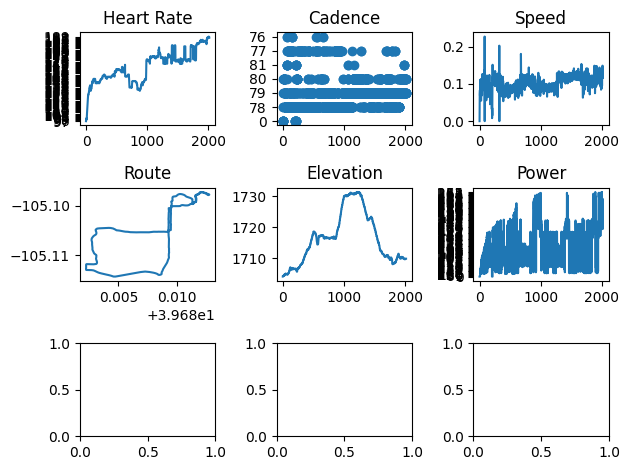

In [63]:
def parse_gpx(file_path):
    # Open and parse the GPX file
    with open(file_path, 'r') as f:
        gpx = gpxpy.parse(f)

    lats = []
    longs = []
    elevations = []
    times = []
    hrs = []
    cadences = []
    powers = []
    
    for track in gpx.tracks:
        for segment in track.segments:
            print(f"Track Name: {track.name}")
            print(f"Track Type: {track.type}")

            for point in segment.points:
                lats.append(point.latitude)
                longs.append(point.longitude)
                elevations.append(point.elevation)
                times.append(point.time)
                
                heart_rate = None
                cadence = None
                if point.extensions:
                    for ext in point.extensions:
                        
                        ext_xml = ET.ElementTree(ext)
                        # Check for the specific tags in the extension using namespaces
                        hr_elem = ext_xml.find('.//{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}hr')
                        cad_elem = ext_xml.find('.//{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}cad')
                        pow_elem = ext_xml.find('power')
                        # Extract heart rate and cadence if found
                        if hr_elem is not None:
                            hrs.append(hr_elem.text)
                        if cad_elem is not None:
                            cadences.append(cad_elem.text)
                        if ext.tag == 'power':
                            powers.append(ext.text)
    return lats, longs, elevations, times, hrs, cadences, powers

# file_path = 'Data/04052025_run.gpx'
# lats, longs, elevations, times, hrs, cadences = parse_gpx(file_path)
# plt.plot(lats, longs00)
# plt.plot([i for i in range(len(hrs))], hrs)


file_path = 'Data/04062025_run.gpx'
lats1, longs1, elevations1, times1, hrs1, cadences1, powers1 = parse_gpx(file_path)

#To get velocity, take change between times (this is 1/sec) of pos data)
vels = []
x_old, y_old = lats1[0], longs1[0]
# print(lats1, longs1)
for i, x in enumerate(lats1):
    y = longs1[i]
    dist = np.sqrt((x_old - x)**2 + (y_old - y)**2)
    vels.append(dist)
    x_old = x
    y_old = y

vels = np.array(vels)
# current units are degrees/sec
vels *= 3600 #convert to degrees/hr
print(np.mean(vels))

fig, ax = plt.subplots(3,3)
xs = [i for i in range(len(hrs1))]
ax[0,0].plot([i for i in range(len(hrs1))], np.array(hrs1))
ax[0,0].set_title("Heart Rate")
ax[0,1].scatter(xs, cadences1)
ax[0,1].set_title("Cadence")
ax[1,0].plot(lats1, longs1)
ax[1,0].set_title("Route")
ax[1,1].plot(xs, elevations1)
ax[1,1].set_title("Elevation")
ax[0,2].plot(xs, vels)
ax[0,2].set_title("Speed")
ax[1,2].plot(xs, powers1)
ax[1,2].set_title("Power")
plt.tight_layout()
# ax.set_yticks(np.arange(90,200,10))
# ax.set_yticklabels(np.arange(90,200,10))
# ax.show()


#need to find some good values to bin on
print(len(lats1))
print(np.min(np.array(lats1)))
print(np.max(np.array(lats1)))
# print(lats1[800:815])

#have 6 decimals to work with, could try binning on 5?
lats1, longs1 = np.around(lats1, decimals=5), np.around(longs1, decimals=5)
# print(lats1[800:815])

#create a zipped list of coordinates, which will be the items in our set

coords = set(zip(lats1, longs1))
# print(coords)

In [64]:
def get_loc_set(filename):
    with open(file_path, 'r') as f:
        gpx = gpxpy.parse(f)

    lats = []
    longs = []
    
    for track in gpx.tracks:
        for segment in track.segments:
            # print(f"Track Name: {track.name}")
            print(f"Track Type: {track.type}")

            for point in segment.points:
                lats.append(point.latitude)
                longs.append(point.longitude)
                
    lats, longs = np.around(lats, decimals=5), np.around(longs, decimals=5)
    return set(zip(lats, longs))
    

In [65]:
filenames = ['Data/04062025_run.gpx', 'Data/04052025_run.gpx', 'Data/04072025_run.gpx', 'Data/04112025_run.gpx', 'Data/04132025_run.gpx']
coords_list = []
for i, file in enumerate(filenames):
    print("Analyzing file", i+1)
    curr_coords = get_loc_set(file)
    coords_list.append(curr_coords)
    

Analyzing file 1
Track Type: running
Analyzing file 2
Track Type: running
Analyzing file 3
Track Type: running
Analyzing file 4
Track Type: running
Analyzing file 5
Track Type: running


In [66]:
import pandas as pd

all_coords = set()
for s in coords_list:
    all_coords = all_coords | s


s0 = pd.Series(list(all_coords))

result_dict = {'checker': s0}

for i, shingle_set in enumerate(coords_list):
    print(i)
    column_name = filenames[i] 
    result_dict[column_name] = s0.isin(pd.Series(list(shingle_set)))

df = pd.DataFrame(result_dict)

print(df)


0
1
2
3
4
                     checker  Data/04062025_run.gpx  Data/04052025_run.gpx  \
0       (39.6895, -105.1028)                   True                   True   
1     (39.68295, -105.11177)                   True                   True   
2     (39.68879, -105.11303)                   True                   True   
3     (39.68312, -105.10537)                   True                   True   
4     (39.69002, -105.09791)                   True                   True   
...                      ...                    ...                    ...   
2005  (39.68956, -105.09937)                   True                   True   
2006   (39.69268, -105.0976)                   True                   True   
2007  (39.69164, -105.09881)                   True                   True   
2008  (39.68297, -105.11176)                   True                   True   
2009  (39.68314, -105.11164)                   True                   True   

      Data/04072025_run.gpx  Data/04112025_run.gpx  D